In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras import models
from keras import Sequential
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.metrics import AUC
from keras.regularizers import L1
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup 
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wmama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wmama\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wmama\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [22]:
colnames=['ID', 'Social network', 'Sentiment', 'Text'] 

In [23]:
df_train = pd.read_csv('twitter_training.csv', names=colnames, header=None)

In [24]:
df_val = pd.read_csv('twitter_validation.csv', names=colnames, header=None)

In [25]:
df_train.head(5)

,ID,Social network,Sentiment,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [26]:
df_val.head(5)

,ID,Social network,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              74682 non-null  int64 
 1   Social network  74682 non-null  object
 2   Sentiment       74682 non-null  object
 3   Text            73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [28]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              1000 non-null   int64 
 1   Social network  1000 non-null   object
 2   Sentiment       1000 non-null   object
 3   Text            1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [29]:
df_train = df_train.replace(to_replace='None', value=np.nan).dropna()

In [30]:
print(f'Train None info:\n{df_train.isnull().sum()}')
print(f'\nValidation None info:\n{df_val.isnull().sum()}')

Train None info:
ID                0
Social network    0
Sentiment         0
Text              0
dtype: int64

Validation None info:
ID                0
Social network    0
Sentiment         0
Text              0
dtype: int64


In [31]:
print("__________TRAIN__________")
print(f"Count of categories: {len(df_train['Sentiment'].unique())}")
print(f"Categories names: {df_train['Sentiment'].unique()}")
print(f"Categories values counts:\n{df_train['Sentiment'].value_counts()}")
print("\n________VALIDATION________")
print(f"Count of categories: {len(df_val['Sentiment'].unique())}")
print(f"Categories names: {df_val['Sentiment'].unique()}")
print(f"Categories values counts:\n{df_val['Sentiment'].value_counts()}")

__________TRAIN__________
Count of categories: 4
Categories names: ['Positive' 'Neutral' 'Negative' 'Irrelevant']
Categories values counts:
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: Sentiment, dtype: int64

________VALIDATION________
Count of categories: 4
Categories names: ['Irrelevant' 'Neutral' 'Negative' 'Positive']
Categories values counts:
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: Sentiment, dtype: int64


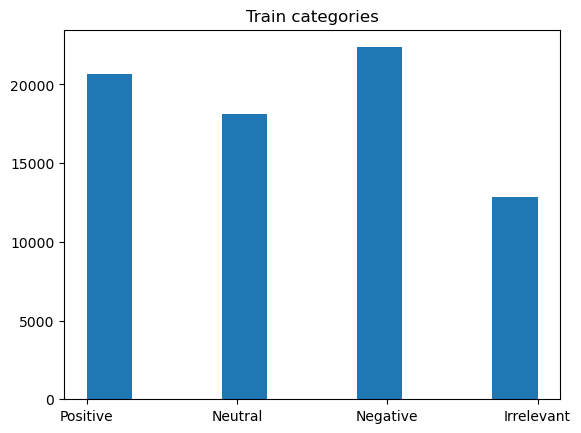

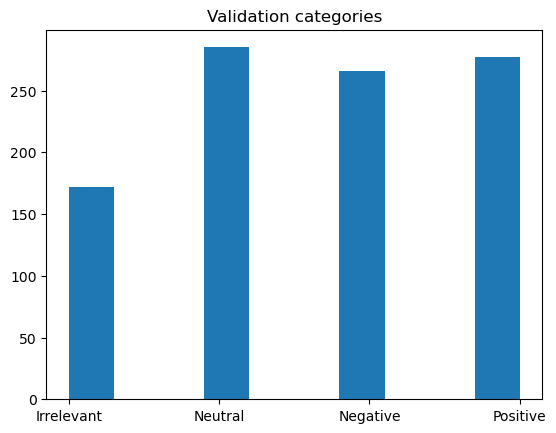

In [32]:
plt.hist(df_train['Sentiment'])
plt.title("Train categories")
plt.show()

plt.hist(df_val['Sentiment'])
plt.title("Validation categories")
plt.show()

In [33]:
def cleaned_review(review):
  stop = stopwords.words("english")
  stop.remove('not')
  stop.remove('no')
  
  lemmatizer = WordNetLemmatizer()
  # убираем теги html
  new_review = BeautifulSoup(review).get_text()
  # убираем url
  no_urls = new_review.replace('http\S+', '').replace('www\S+', '')
  # убираем символы кроме букв
  clean_review = re.sub("[^a-zA-Z]", " ", no_urls)
  # приводим в нижнему регистру
  new_words = clean_review.lower().split()
  # лематизируем и убираем стоп-слова
  final_words = [lemmatizer.lemmatize(word) for word in new_words if not word in stop]
    
  return (" ".join(final_words))

In [34]:
df_train['Text'] = df_train['Text'].apply(lambda x:cleaned_review(x))

c:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [35]:
df_val['Text'] = df_val['Text'].apply(lambda x:cleaned_review(x))

In [36]:
train_data = df_train['Text'].to_list()
val_data = df_val['Text'].to_list()

train_data = np.concatenate([train_data, val_data])

In [37]:
train_categ = df_train['Sentiment']
val_categ = df_val['Sentiment']

In [38]:
labels = list(df_train['Sentiment'].unique())
label2id = {v:k for k,v in enumerate(labels)}
print(labels)
print(label2id)

['Positive', 'Neutral', 'Negative', 'Irrelevant']
{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}


In [39]:
train_targets = np.array(df_train["Sentiment"].map(label2id).to_list())
val_targets = np.array(df_val['Sentiment'].map(label2id).to_list())
train_targets = np.concatenate([train_targets, val_targets])

In [40]:
max_len = 128   # отсечение остатка отзывов после 500-го слова
max_words = 27191     # рассмотрение только 10_000 наиболее часто используемых слов

tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # создаем токенайзер
vocab = tokenizer.fit_on_texts(train_data)   # создаем словарь на основе слов из текста 
sequences = tokenizer.texts_to_sequences(train_data) # преобразуем каждый текст в последовательность чисел

In [41]:
sequences[0]

[205, 100, 67, 1441]

In [42]:
tokenizer.sequences_to_texts(
    sequences[:1]
)

['im getting borderland murder']

In [43]:
word_index = tokenizer.word_index   # получаем количество уникальных слов
print('Found %s unique tokens'%len(word_index))

Found 27192 unique tokens


In [44]:
train_texts = pad_sequences(sequences, maxlen=max_len)   # преобразуем в массив numpy размером (num_samples, max_len)

In [45]:
print(train_texts.shape)

(74996, 128)


In [46]:
indices = np.arange(train_targets.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
train_texts = train_texts[indices]
train_targets = train_targets[indices]
# train test split
test_texts = train_texts[:10_000]
test_targets = train_targets[:10_000]

train_texts = train_texts[10_000:]
train_targets = train_targets[10_000:]

In [47]:
train_targets = to_categorical(train_targets)
test_targets = to_categorical(test_targets)

In [48]:
print(f"Train texts shape: {train_texts.shape}")
print(f"Test texts shape: {test_texts.shape}")

Train texts shape: (64996, 128)
Test texts shape: (10000, 128)


In [49]:
print(f"Train targets shape: {train_targets.shape}")
print(f"Test targets shape: {test_targets.shape}")

Train targets shape: (64996, 4)
Test targets shape: (10000, 4)


In [50]:
def build_model():
  model = Sequential()
  model.add(layers.Embedding(input_dim=max_words, output_dim=128))
  model.add(layers.Bidirectional(layers.LSTM(units=128, return_sequences=True)))
  model.add(layers.Bidirectional(layers.LSTM(units=64)))   # LSTM(16, recurrent_dropout=0.2))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(units=128, activation='relu'))  # , kernel_regularizer=L1(0.01)
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [51]:
model = build_model()

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3480448   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [54]:
model.layers[1]

In [56]:
for i in model.layers[1].weights:
    print(i.shape)

(128, 512)
(128, 512)
(512,)
(128, 512)
(128, 512)
(512,)


In [57]:
128*4

512

In [ ]:
#(k, 4*n)
#(n, n*4)
#(4*n)

In [52]:
[1*128]

[128]

In [166]:
# def build_model():
#   model = Sequential()
#   model.add(layers.Embedding(input_dim=max_words, output_dim=128))
#   model.add(layers.Bidirectional(layers.SimpleRNN(units=128, return_sequences=True)))
#   model.add(layers.Bidirectional(layers.SimpleRNN(units=64)))   # LSTM(16, recurrent_dropout=0.2))
#   model.add(layers.Dropout(0.5))
#   model.add(layers.Dense(units=128, activation='relu'))  # , kernel_regularizer=L1(0.01)
#   model.add(layers.Dropout(0.5))
#   model.add(layers.Dense(4, activation='softmax'))

#   return model

In [196]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint(filepath='weights1.h5', save_best_only = True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [197]:
model = build_model()

In [198]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 128)         3480448   
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 256)        263168    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dropout_27 (Dropout)        (None, 128)             

In [199]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['acc', AUC()])
history = model.fit(train_texts, train_targets, epochs=20, validation_split=0.2, batch_size=256, callbacks=[checkpoint,lr_scheduler])

Epoch 1/20
204/204 [==============================] - 18s 70ms/step - loss: 1.0699 - acc: 0.5517 - auc_13: 0.7935 - val_loss: 0.9308 - val_acc: 0.6094 - val_auc_13: 0.8496 - lr: 0.0010
Epoch 2/20
204/204 [==============================] - 13s 65ms/step - loss: 0.6184 - acc: 0.7772 - auc_13: 0.9356 - val_loss: 0.5810 - val_acc: 0.7899 - val_auc_13: 0.9429 - lr: 0.0010
Epoch 3/20
204/204 [==============================] - 13s 65ms/step - loss: 0.4086 - acc: 0.8570 - auc_13: 0.9712 - val_loss: 0.5087 - val_acc: 0.8185 - val_auc_13: 0.9588 - lr: 0.0010
Epoch 4/20
204/204 [==============================] - 14s 68ms/step - loss: 0.3129 - acc: 0.8892 - auc_13: 0.9828 - val_loss: 0.4873 - val_acc: 0.8293 - val_auc_13: 0.9612 - lr: 0.0010
Epoch 5/20
204/204 [==============================] - 13s 66ms/step - loss: 0.2556 - acc: 0.9082 - auc_13: 0.9882 - val_loss: 0.4125 - val_acc: 0.8670 - val_auc_13: 0.9728 - lr: 0.0010
Epoch 6/20
204/204 [==============================] - 13s 64ms/step - loss:

In [173]:
train_texts

array([[    0,     0,     0, ...,    24,    76,  1329],
       [    0,     0,     0, ...,   432,   530, 14412],
       [    0,     0,     0, ...,     0,  2119,   658],
       ...,
       [    0,     0,     0, ...,    13,   332,   576],
       [    0,     0,     0, ...,  5049,  2798,   368],
       [    0,     0,     0, ...,     2, 15716,  6415]])

In [108]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['acc', AUC()])
history = model.fit(train_texts, train_targets, epochs=20, validation_split=0.2, batch_size=256, callbacks=[checkpoint,lr_scheduler])

Epoch 1/20
204/204 [==============================] - 19s 71ms/step - loss: 1.0705 - acc: 0.5491 - auc_6: 0.7937 - val_loss: 0.7903 - val_acc: 0.6935 - val_auc_6: 0.8938 - lr: 0.0010
Epoch 2/20
204/204 [==============================] - 13s 65ms/step - loss: 0.6051 - acc: 0.7812 - auc_6: 0.9380 - val_loss: 0.7337 - val_acc: 0.7662 - val_auc_6: 0.9248 - lr: 0.0010
Epoch 3/20
204/204 [==============================] - 13s 62ms/step - loss: 0.4044 - acc: 0.8591 - auc_6: 0.9718 - val_loss: 0.4972 - val_acc: 0.8259 - val_auc_6: 0.9598 - lr: 0.0010
Epoch 4/20
204/204 [==============================] - 14s 68ms/step - loss: 0.3112 - acc: 0.8911 - auc_6: 0.9829 - val_loss: 0.4475 - val_acc: 0.8381 - val_auc_6: 0.9671 - lr: 0.0010
Epoch 5/20
204/204 [==============================] - 14s 67ms/step - loss: 0.2547 - acc: 0.9090 - auc_6: 0.9884 - val_loss: 0.4429 - val_acc: 0.8575 - val_auc_6: 0.9702 - lr: 0.0010
Epoch 6/20
204/204 [==============================] - 14s 67ms/step - loss: 0.2198 - 

In [109]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 128)         3468800   
                                                                 
 bidirectional_12 (Bidirecti  (None, None, 256)        263168    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              164352    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)              

In [110]:
model.evaluate(test_texts, test_targets)

313/313 [==============================] - 4s 13ms/step - loss: 0.5890 - acc: 0.8838 - auc_6: 0.9668


[0.5890095829963684, 0.8838000297546387, 0.9667635560035706]

In [45]:
def show_all_metrics_dependencies(history):
  epochs = range(1, len(list(history.history.values())[0]) + 1)
  keys = list(history.history.keys())
  i = 0
  while len(keys) > 0:
    tmp = keys[0]
    if keys[i].find(tmp) and keys[i].find(tmp) > 0:
      metrics = keys[i]
      plt.plot(range(1, len(history.history[tmp]) + 1), history.history[tmp], 'ro', label='Train ' + tmp)
      plt.plot(range(1, len(history.history[metrics]) + 1), history.history[metrics], 'r', label='Validation ' + metrics)
      plt.title("Training and validation " + tmp)
      plt.xlabel('Epochs')
      plt.ylabel(tmp.capitalize())
      plt.legend()
      plt.show()
      keys.remove(metrics)
      keys.remove(tmp)
      i = 0
    i+=1

In [46]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         1280000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 256)        263168    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [200]:
#history.history

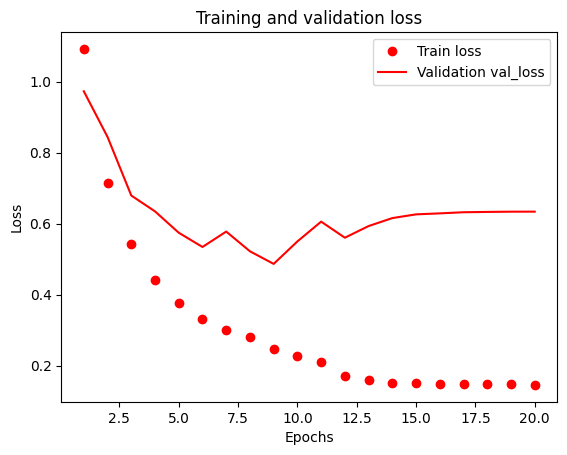

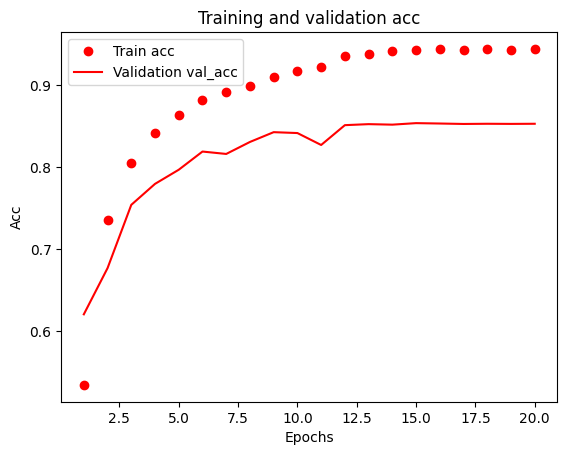

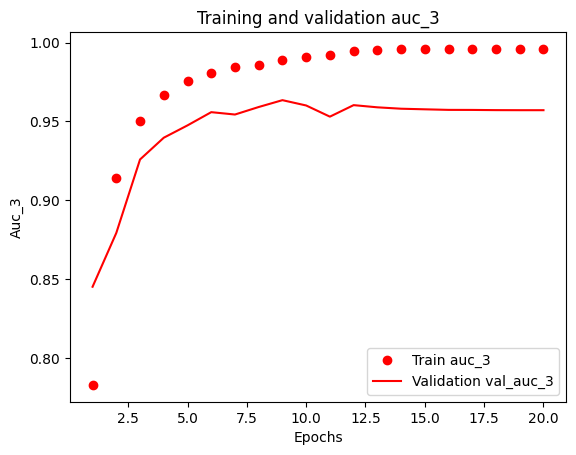

IndexError: list index out of range

In [48]:
show_all_metrics_dependencies(history)

In [ ]:
saved_model = models.load_model('/content/weights1.h5')
saved_model.evaluate(test_texts, test_targets)
# [0.5164545178413391, 0.8312000036239624, 0.9598228335380554]
# [0.5110083222389221, 0.8357999920845032, 0.96224045753479]
# [0.5580860376358032, 0.8274000287055969, 0.9563339352607727]
# [0.5494359135627747, 0.8363999724388123, 0.9585456848144531]
# [0.5061720609664917, 0.8385000228881836, 0.9618826508522034]